In [1]:
import json
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load the JSON file
with open('Bird/annotations/train_annotations.json', 'r') as f:
    annotations = json.load(f)

In [2]:
def load_dataset(annotations, image_dir, input_shape=(128, 128), num_classes=3):
    images = []
    bboxes = []
    labels = []

    for annotation in annotations['annotations']:
        image_id = annotation['image_id']
        bbox = annotation['bbox']  # [x, y, width, height]
        category_id = annotation['category_id']

        # Load the image
        image_info = next(item for item in annotations['images'] if item['id'] == image_id)
        image_path = f"{image_dir}/{image_info['file_name']}"
        image = cv2.imread(image_path)
        image = cv2.resize(image, input_shape[:2])

        # Normalize the bounding box
        x_min, y_min, width, height = bbox
        x_max = x_min + width
        y_max = y_min + height

        x_min /= image_info['width']
        y_min /= image_info['height']
        x_max /= image_info['width']
        y_max /= image_info['height']

        # Append the data
        images.append(image)
        bboxes.append([x_min, y_min, x_max, y_max])
        labels.append(category_id)

    images = np.array(images)
    bboxes = np.array(bboxes)
    labels = to_categorical(labels, num_classes=num_classes)

    return images, bboxes, labels

# Specify the directory where images are stored
image_dir = r'Bird/images/train'

# Load the dataset
X, y_bboxes, y_labels = load_dataset(annotations, image_dir, input_shape=(128, 128), num_classes=3)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_bboxes_train, y_bboxes_val, y_labels_train, y_labels_val = train_test_split(
    X, y_bboxes, y_labels, test_size=0.2, random_state=42)

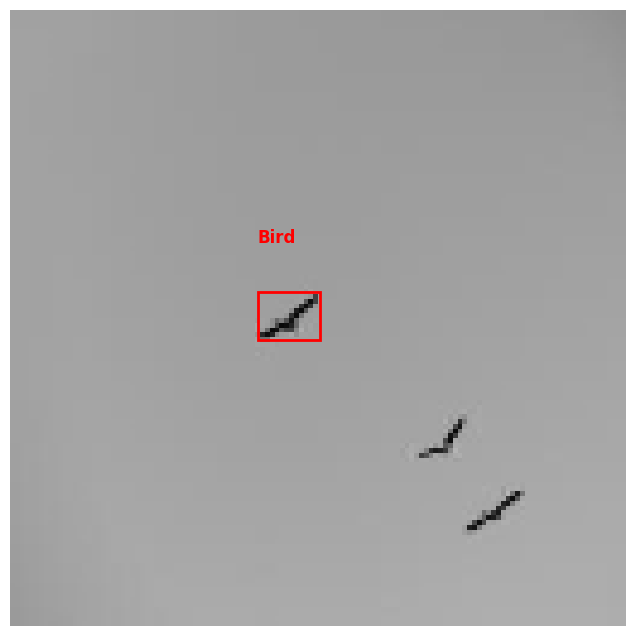

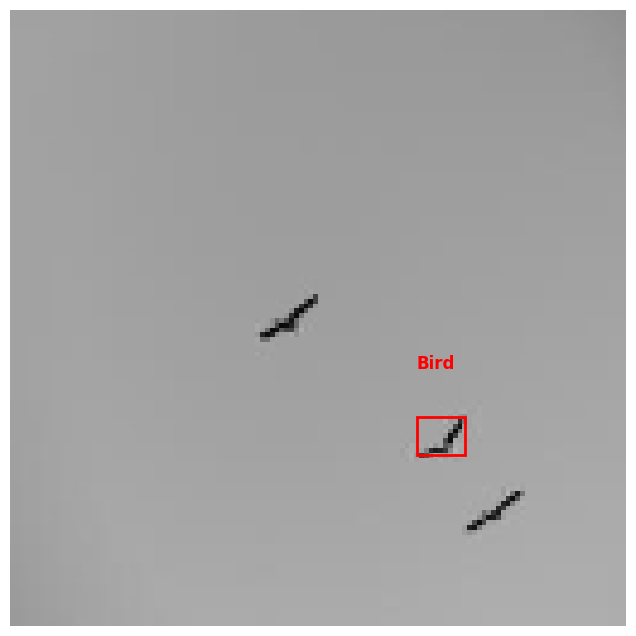

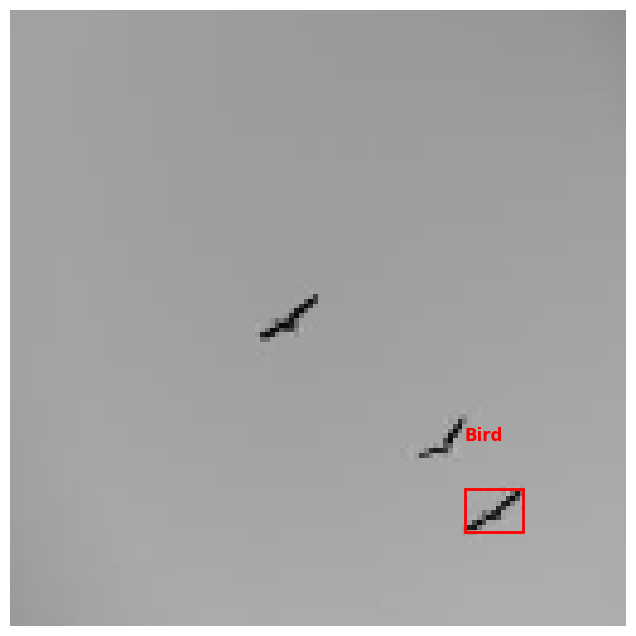

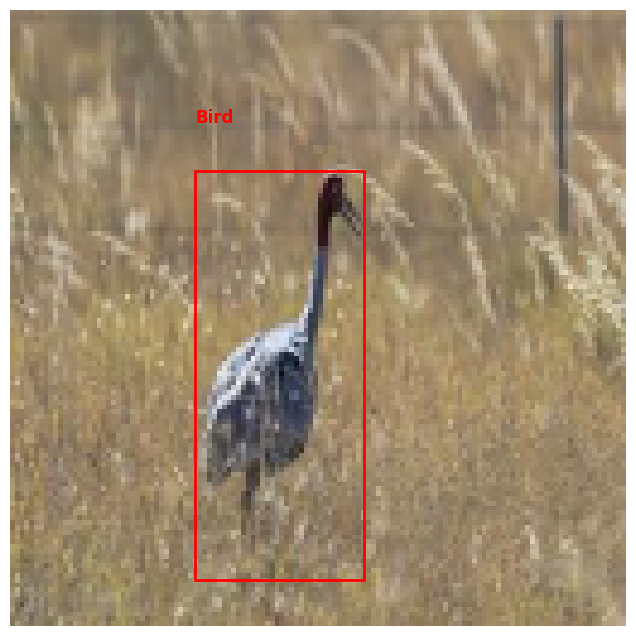

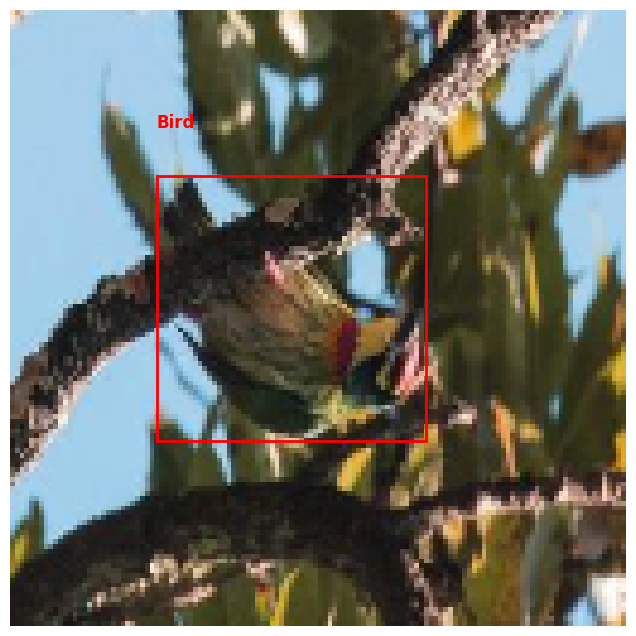

In [4]:
import matplotlib.pyplot as plt

# Class names (replace these with your actual class names)
class_names = {0: 'SuperBird', 1: 'Bird', 2: 'Background'}

def visualize_dataset(images, bboxes, labels, num_images=5):
    for i in range(num_images):
        image = images[i]
        bbox = bboxes[i]
        label = labels[i]

        # Denormalize bounding box
        h, w, _ = image.shape
        x_min, y_min, x_max, y_max = bbox
        x_min = int(x_min * w)
        y_min = int(y_min * h)
        x_max = int(x_max * w)
        y_max = int(y_max * h)

        # Plot the image
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Plot the bounding box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          edgecolor='red', facecolor='none', linewidth=2))

        # Plot the label
        label_idx = np.argmax(label)  # Get the index of the class
        class_name = class_names[label_idx]
        plt.text(x_min, y_min - 10, class_name, color='red', fontsize=12, weight='bold')

        plt.axis('off')
        plt.show()

# Visualize 5 images
visualize_dataset(X, y_bboxes, y_labels, num_images=5)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

In [6]:
#Load pre-trained model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load MobileNetV2 with reduced input size
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for your task
x = base_model.output
x = GlobalAveragePooling2D()(x)
bbox_output = Dense(4, activation='linear', name='bbox_output')(x)
class_output = Dense(3, activation='softmax', name='class_output')(x)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [7]:
# Create the model
model = Model(inputs=base_model.input, outputs=[bbox_output, class_output])

In [8]:
from tensorflow.keras.callbacks import TensorBoard

# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)


In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss={'bbox_output': 'mean_squared_error', 'class_output': 'categorical_crossentropy'},
              metrics={'bbox_output': 'mse', 'class_output': 'accuracy'})


In [11]:
# Assuming X_train is your input images, y_bbox_train is the bounding box labels, and y_class_train is the class labels
history = model.fit(
    X_train,  # Your training data
    {'bbox_output': y_bboxes_train, 'class_output': y_labels_train},  # Your labels for bounding boxes and class predictions
    validation_data=(X_val, {'bbox_output': y_bboxes_val, 'class_output': y_labels_val}),  # Validation data and labels
    epochs=10,  # Number of epochs
    batch_size=32,  # Batch size for training
    verbose=1  # To show progress during training
)


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 49s 207ms/step - bbox_output_loss: 0.3999 - bbox_output_mse: 0.3999 - class_output_accuracy: 0.9427 - class_output_loss: 0.1548 - loss: 0.5547 - val_bbox_output_loss: 0.1053 - val_bbox_output_mse: 0.1053 - val_class_output_accuracy: 0.9986 - val_class_output_loss: 0.0178 - val_loss: 0.1231
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 34s 189ms/step - bbox_output_loss: 0.0908 - bbox_output_mse: 0.0908 - class_output_accuracy: 0.9981 - class_output_loss: 0.0161 - loss: 0.1070 - val_bbox_output_loss: 0.0748 - val_bbox_output_mse: 0.0748 - val_class_output_accuracy: 0.9986 - val_class_output_loss: 0.0115 - val_loss: 0.0863
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 33s 185ms/step - bbox_output_loss: 0.0683 - bbox_output_mse: 0.0683 - class_output_accuracy: 0.9990 - class_output_loss: 0.0093 - loss: 0.0776 - val_bbox_output_loss: 0.0651 - val_bbox_output_mse: 0.0651 - val_class_output_accuracy: 0.9993 - val_class_output_loss: 0.0111 - val_loss: 0.0762
Epoch 4

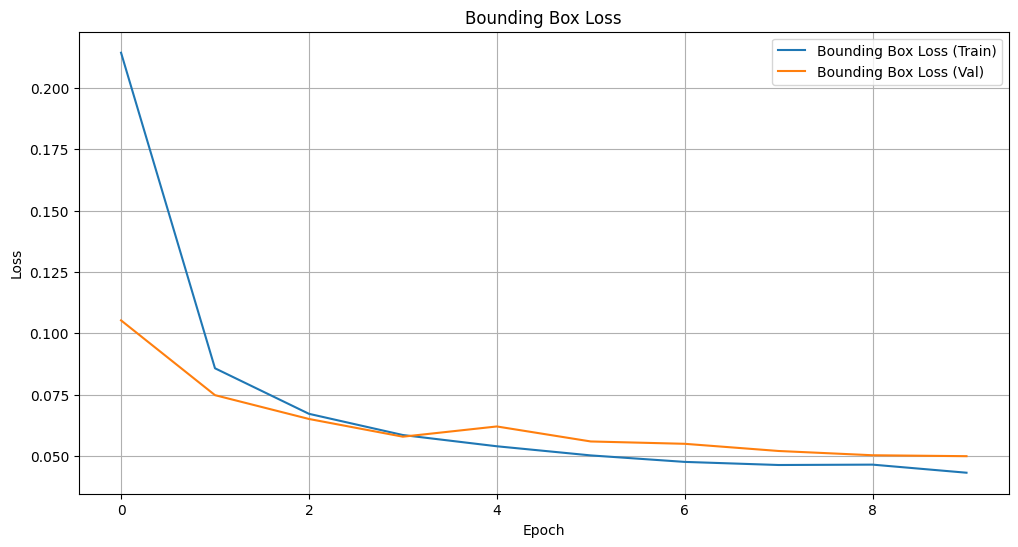

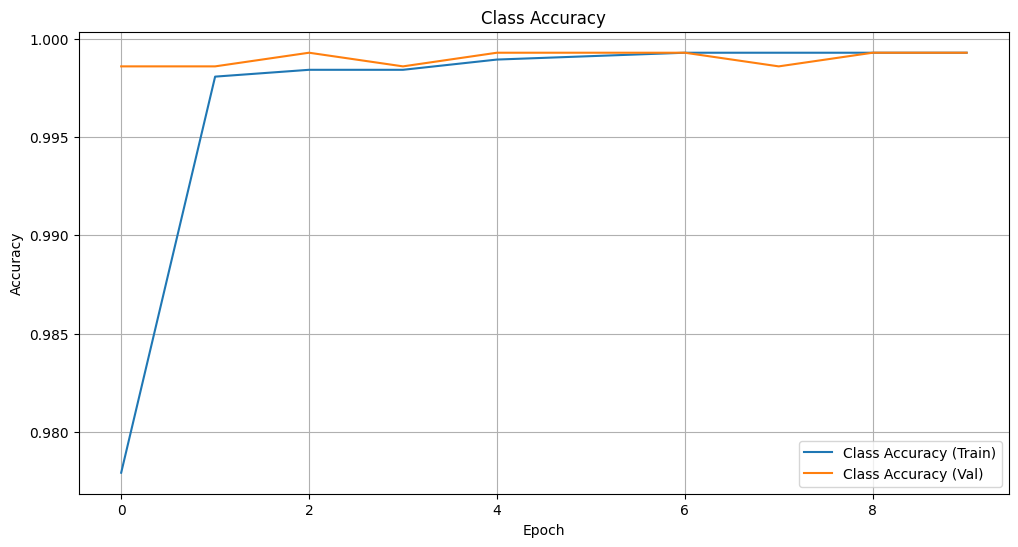

In [12]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Plot bounding box loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['bbox_output_loss'], label='Bounding Box Loss (Train)')
    plt.plot(history.history['val_bbox_output_loss'], label='Bounding Box Loss (Val)')
    plt.title('Bounding Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot class accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['class_output_accuracy'], label='Class Accuracy (Train)')
    plt.plot(history.history['val_class_output_accuracy'], label='Class Accuracy (Val)')
    plt.title('Class Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Plot the metrics
plot_metrics(history)

In [13]:
# Save the entire model to a file
model.save('Bird/trained_models/newModel/my_PTmodel.h5')

In [14]:
from tensorflow.keras.models import load_model

# Load the previously saved model
loaded_model = load_model('Bird/trained_models/newModel/my_PTmodel.h5')

In [15]:
import tensorflow as tf

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('Bird/trained_models/newModel/my_PTmodel.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\omini\AppData\Local\Temp\tmpbfnkafq5\assets


INFO:tensorflow:Assets written to: C:\Users\omini\AppData\Local\Temp\tmpbfnkafq5\assets


Saved artifact at 'C:\Users\omini\AppData\Local\Temp\tmpbfnkafq5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  List[TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)]
Captures:
  3016158154000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016158154192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016158151504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016158151312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016158158224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016161147792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016161132816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016161146448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016161133200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016161148

In [16]:
import tensorflow as tf

# Load the trained model (assuming your model is saved in a file)
model = tf.keras.models.load_model('Bird/trained_models/newModel/my_PTmodel.h5')

# Create a converter object
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set the optimization flag to enable quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Specify representative dataset function for full integer quantization
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):  # Example with 100 samples
        yield [tf.cast(input_value, tf.float32)]

# Set the representative dataset for full integer quantization
converter.representative_dataset = representative_data_gen

# Specify the target data type
#converter.target_spec.supported_types = [tf.float16]  # This will result in float16 quantization
# If you want full int8 quantization, include:
converter.target_spec.supported_types = [tf.int8]

# Ensure that input and output tensors are also quantized to int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert the model to TensorFlow Lite format with int8 quantization
tflite_quant_model = converter.convert()

# Save the quantized model
with open('Bird/trained_models/newModel/my_PTmodel_quantized_int8.tflite', 'wb') as f:
    f.write(tflite_quant_model)


INFO:tensorflow:Assets written to: C:\Users\omini\AppData\Local\Temp\tmpm57qpmuk\assets


INFO:tensorflow:Assets written to: C:\Users\omini\AppData\Local\Temp\tmpm57qpmuk\assets


Saved artifact at 'C:\Users\omini\AppData\Local\Temp\tmpm57qpmuk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  List[TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)]
Captures:
  3016395651024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016420606032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016420606608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016395652560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016395651216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016420607184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016420608528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016420608720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016420608336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3016420607

F:\Bird_Data\roboEnv\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [24]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

# Prune the model
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, 0)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# Re-compile and re-train the pruned model
model_for_pruning.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_for_pruning.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val))

# Strip pruning and convert to TFLite
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_pruned_quant_model = converter.convert()

# Save the pruned and quantized model
with open('Bird/trained_models/newModel/my_PTmodel_pruned_quantized_int8.tflite', 'wb') as f:
    f.write(tflite_pruned_quant_model)


ModuleNotFoundError: No module named 'tf_keras'

In [21]:
!pip install tensorflow-model-optimization

  Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl.metadata (904 bytes)
  Using cached absl_py-1.4.0-py3-none-any.whl.metadata (2.3 kB)
Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl (242 kB)
Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Attempting uninstall: absl-py
    Found existing installation: absl-py 2.1.0
    Uninstalling absl-py-2.1.0:
      Successfully uninstalled absl-py-2.1.0


In [25]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [26]:
from tensorflow import keras
print(keras.__version__)


3.5.0
